In [1]:
!pip install opencv-python pandas scikit-learn torch torchvision pillow torchmetrics
!pip install plotly


  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/6d/e6/e51997d1818a4c1a1ad2b1c7ca5ff9dd95969596add58b2ed39479026964/torchmetrics-1.4.0.post0-py3-none-any.whl.metadata
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl.metadata (19 kB)
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/75/6c/ccad49b96b38758ac77b04dc6d3795fb460fe0f8f311c75d0af0f8085cfb/lightning_utilities-0.11.3.post0-py3-none-any.whl.metadata
  Using cached lightning_utilities-0.11.3.post0-py3-none-any.whl.metadata (4.7 kB)
Using cached torchmetrics-1.4.0.post0-py3-none-any.whl (868 kB)
Using cached lightning_utilities-0.11.3.post0-py3-none-any.whl (26 kB)
  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/0b/f8/b65cdd2be32e442c4efe7b672f73c90b05eab5a7f3f4115efe181d432c60/plotly-5.22.0-py3-none-any.whl.metadata
  Using cached plotly-5.22.0-py3-none-any.whl.metadata (7.

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import r2_score
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import functional as F
import pickle
import multiprocessing as mp
import cv2
import numpy as np
from skimage import color
from torchmetrics.regression import R2Score
import random

from torchvision.models import ResNet18_Weights, ResNet50_Weights

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


import multiprocessing as mp
from multiprocessing import get_context

cpus = mp.cpu_count()
cpus

128

In [36]:
# Navigate back to the root directory -- do it 2 times
os.chdir('..')
os.chdir('..')



# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)



Current working directory: /home/jovyan


In [29]:
# Change to the directory containing the images
os.chdir('images_output/output_images')

# List of available image files in the directory
available_images = set(os.listdir('.'))

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)

Current working directory: /home/jovyan/images_output/output_images


In [13]:
available_images

{'amatechblog-1731442300259096147.jpg',
 'gingeybites-1854341242214051414.jpg',
 'jenniferlake-1846152258163010478.jpg',
 'meglan8-1743144280099988243.jpg',
 'thewanderfuladventure-1733530062798358603.jpg',
 'thewandertog-1831335703080713536.jpg',
 'gage_forster-1550401558708139752.jpg',
 'sweetbabycharlie-1630685107030848708.jpg',
 'somethingnavy-1955271356984913978.jpg',
 'yyyyyyyyooo1-1939850529496820369.jpg',
 'melina.kes-1275943895062887311.jpg',
 'paigewallbankxo-1864164476556123012.jpg',
 'goodiegoodieglutenfree-1522618266168845611.jpg',
 'kate.ovens-1621827869972074283.jpg',
 'silaswhippet-1208921356241484445.jpg',
 'jonbrownell-1315004203194070701.jpg',
 'kidfriendlydc-1626358645939618076.jpg',
 'the_forest_cantina-1645162642217594093.jpg',
 'thewanderingkansan-1819186601357973909.jpg',
 'thedaydreamdiaries-1296019368459379166.jpg',
 'toronto.fitchick.sofia-1675631603433236037.jpg',
 'milie_cqcb-1844478321662218191.jpg',
 'ems_button-1651704731569013674.jpg',
 'bennicullen-167

In [6]:
list(available_images)[0]

'theresehoff-1861885284793045873.jpg'

In [4]:
import torchvision
def get_model(device='cuda', model_name='v1'):
    # Load the model.
    if model_name == 'v2':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
            weights='DEFAULT'
        )
    elif model_name == 'v1':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights='DEFAULT'
        )
    # Load the model onto the computation device.
    model = model.eval().to(device)
    return model

In [3]:
# Define the computation device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.6)
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [6]:
def image_process(args):
    # Read the image.
    #image_data = []
    #for image_name in os.listdir(image_path):
    #img_path = os.path.join(image_path, image_name)
    
    image_path, weights = args
        
    image = Image.open(image_path).convert('RGB')
    img = transforms.Compose([transforms.PILToTensor()])(image).to(device)
    preprocess = weights.transforms()

    batch = [preprocess(img)]
    prediction = model(batch)[0]
    '''image_data.append({
            'image_name': image_name,
            'boxes': prediction['boxes'].tolist(),  # Convert numpy array to list
            'labels': prediction['labels'].tolist(),  # Convert numpy array to list
            'scores': prediction['scores'].tolist()  # Convert numpy array to list
        })'''
    return {
        'image_name': os.path.basename(image_path),
        'boxes': prediction['boxes'].tolist(),  # Convert numpy array to list
        'labels': prediction['labels'].tolist(),  # Convert numpy array to list
        'scores': prediction['scores'].tolist()  # Convert numpy array to list
    }
        
#return prediction


In [4]:
merged_posts_data = pd.read_csv('filtered_mapped_posts_2k_per_inflCateg.csv')

merged_posts_data_no_duplicates = merged_posts_data.drop_duplicates()


# Construct the image file name and check if it exists in the directory
merged_posts_data_no_duplicates['constructed_file_name'] = merged_posts_data_no_duplicates['OwnerUsername'] + '-' + merged_posts_data_no_duplicates['Image_file_name'] 

# Change to the directory containing the images
os.chdir('images_output/output_images')

# List of available image files in the directory
available_images = set(os.listdir('.'))


# Navigate back to the root directory -- do it 2 times
os.chdir('..')
os.chdir('..')

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)


# Filter the DataFrame to only include rows with existing images
filtered_df = merged_posts_data_no_duplicates[merged_posts_data_no_duplicates['constructed_file_name'].isin(available_images)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_8387/4057709760.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Current working directory: /home/jovyan


In [5]:
# Combine image paths with weights


# Directory containing your images
image_dir = 'images_output/output_images'

img_paths = [os.path.join(image_dir, filtered_df.iloc[idx]['constructed_file_name']) for idx in range(len(filtered_df))]
            


Process SpawnPoolWorker-476:
Traceback (most recent call last):
Process SpawnPoolWorker-475:
Traceback (most recent call last):
Process SpawnPoolWorker-479:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

Process SpawnPoolWorker-488:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/op

Process SpawnPoolWorker-504:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-505:
Traceback (most recent call last):
Process SpawnPoolWorker-507:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

Process SpawnPoolWorker-515:
Traceback (most recent call last):
Process SpawnPoolWorker-516:
Traceback (most recent call last):
Process SpawnPoolWorker-517:
Traceback (most recent call last):
Process SpawnPoolWorker-518:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.p

Traceback (most recent call last):
Process SpawnPoolWorker-534:
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task =

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-544:
Traceback (most recent call last):
Process SpawnPoolWorker-545:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-556:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-557:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-569:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-570:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-583:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-584:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-597:
Traceback (most recent call last):
Process SpawnPoolWorker-598:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-610:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-611:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-624:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-625:
Traceback (most recent call last):
Process SpawnPoolWorker-626:
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.1

Process SpawnPoolWorker-637:
Traceback (most recent call last):
Process SpawnPoolWorker-638:
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-650:
Traceback (most recent call last):
Process SpawnPoolWorker-651:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-664:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-663:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-676:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-677:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-689:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-690:
Traceback (most recent call last):
Process SpawnPoolWorker-691:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in 

Process SpawnPoolWorker-717:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-718:
Traceback (most recent call last):
Process SpawnPoolWorker-719:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-731:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/op

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-745:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/op

Process SpawnPoolWorker-759:
Traceback (most recent call last):
Process SpawnPoolWorker-760:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-758:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

Process SpawnPoolWorker-771:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-772:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-785:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-787:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-800:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/op

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in 

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-826:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/op

Process SpawnPoolWorker-839:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/op

Process SpawnPoolWorker-851:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-852:
Traceback (most recent call last):
Process SpawnPoolWorker-853:
Traceback (most recent call last):
Process SpawnPoolWorker-854:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.p

Process SpawnPoolWorker-865:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-864:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

Process SpawnPoolWorker-877:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-878:
Traceback (most recent call last):
Process SpawnPoolWorker-879:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

Process SpawnPoolWorker-890:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'image_process' on <module '__main__' (built-in)>
Process SpawnPoolWorker-891:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", l

  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/conda/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/

  File "/opt/conda/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/conda/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._tar

KeyboardInterrupt: 

ne 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/conda/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/conda/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return 

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
import os
import csv
import contextlib


# Create a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir,img_paths, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform
        self.img_paths = img_paths 

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        #img_name = self.image_files[idx]
        img_path = self.img_paths[idx] #os.path.join(self.image_dir, img_name)
        img_name = os.path.basename(img_path)
        
        #img_paths = [os.path.join(image_dir, filtered_df.iloc[idx]['constructed_file_name']) for idx in range(len(filtered_df))]
  
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image) #.unsqueeze(0).to(device)  # Add batch dimension and move to device


        return image, img_name

# Define the torchvision image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts image to PyTorch tensor and scales pixel values to [0, 1]
])

# Create the dataset and dataloader
image_dir = 'images_output/output_images'
dataset = ImageDataset(image_dir, img_paths,  transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)

# Open the CSV file in write mode initially to write headers
csv_file = 'Rcnn_detection_results.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['image_name', 'box_x1', 'box_y1', 'box_x2', 'box_y2', 'confidence', 'class'])

# Function to perform inference and process results
def process_batch(images, img_names):
    images = images.to(device)
    #with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        #results = yolo.predict(source=images, save=True, imgsz=320, conf=0.4)  # Suppress output

    #results = yolo.predict(source=images, save=False, imgsz=320, conf=0.4 ,verbose=False)  #yolo(image_tensor)


    #img = transforms.Compose([transforms.PILToTensor()])(image).to(device)
    preprocess = weights.transforms()

    batch = [preprocess(image) for image in images]
    prediction = model(batch)[0]


    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        for i, result in enumerate(prediction):
            boxes = prediction['boxes'].cpu().detach().numpy()
            
            labels = prediction['labels'].cpu().detach().numpy()
            confidences = prediction['scores'].cpu().detach().numpy()
            img_name = img_names[i]

            for box, label, confidence in zip(boxes, labels, confidences):
                x1, y1, x2, y2 = box
                writer.writerow([img_name, x1, y1, x2, y2, confidence, label])
            
            #print(f"Processed {img_name} with {len(boxes)} objects detected.")

# Iterate through the dataloader and process images
for batch in dataloader:
    images, img_names = batch
    process_batch(images, img_names)

In [7]:
# Clear CUDA cache to free up memory
torch.cuda.empty_cache()

In [ ]:
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights


def main():
    
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.6)
    model.eval()
    model.to(device)


    model_state_dict = model.state_dict()  # Get the state dict of the model
    
    # Directory containing your images

    image_dir = 'images_output/output_images'
    
    img_paths = [os.path.join(image_dir, filtered_df.iloc[idx]['constructed_file_name']) for idx in range(len(filtered_df))]
    

    # Combine image paths with weights
    args = [(img_path, weights) for img_path in img_paths]


            

    # Use 'spawn' start method for using CUDA

    ctx = get_context('spawn')

    pool = ctx.Pool(mp.cpu_count())

    #pool = mp.Pool(mp.cpu_count())

    #with Pool() as pool:

    results = pool.map(image_process, args)

    pool.close()

    pool.join()

    # Convert results to DataFrame
    image_df = pd.DataFrame(results)
    print(image_df.head())

if __name__ == '__main__':
    main()

In [ ]:
print(image_df.head())

In [ ]:
image_df.to_csv('classified_imag_labels.csv', index=False)

In [30]:
# Read the image.
image1 = Image.open(list(available_images)[0]).convert('RGB')
img1 = transforms.Compose([transforms.PILToTensor()])(image).to(device)

image2 = Image.open(list(available_images)[1]).convert('RGB')
img2 = transforms.Compose([transforms.PILToTensor()])(image).to(device)

images = [img1, img2]

In [ ]:
#images = list(image.to(device) for image in images)
with torch.no_grad():
    results = model(images)

In [35]:
img = transforms.Compose([transforms.PILToTensor()])(image).to(device)
preprocess = weights.transforms()
batch = [preprocess(img)]

In [16]:
prediction = model(batch)[0]
prediction 

{'boxes': tensor([[3.0388e+00, 1.6361e+00, 3.2821e+02, 2.5600e+02],
         [0.0000e+00, 1.1840e+02, 2.7824e+02, 2.5110e+02],
         [1.8400e+02, 5.7508e-02, 2.9247e+02, 1.7666e+02]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([ 1,  1, 77], device='cuda:0'),
 'scores': tensor([0.9368, 0.8370, 0.7536], device='cuda:0', grad_fn=<IndexBackward0>)}

In [25]:
prediction['boxes'].cpu().detach().numpy()


array([[3.0388277e+00, 1.6361234e+00, 3.2821402e+02, 2.5600000e+02],
       [0.0000000e+00, 1.1839857e+02, 2.7823901e+02, 2.5110425e+02],
       [1.8399841e+02, 5.7507522e-02, 2.9247067e+02, 1.7666310e+02]],
      dtype=float32)

In [26]:
prediction['boxes'].tolist()

[[3.038827657699585, 1.6361234188079834, 328.2140197753906, 256.0],
 [0.0, 118.39856719970703, 278.239013671875, 251.104248046875],
 [183.9984130859375,
  0.05750752240419388,
  292.4706726074219,
  176.66310119628906]]

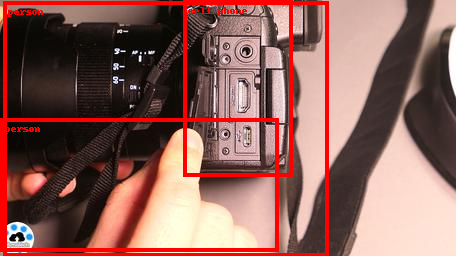

In [17]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img,
                          boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4)
im = to_pil_image(box.detach())
display(im)